# Dubins Car

The Dubins car problem is non-holonomic, and while each configuration is possible, the manner in which those configurations can be reached is reduced. Notably we have $$\dot y \cos \theta - \dot x \sin \theta = 0$$

Hence, unlike for the other examples we cannot rely on the linearized LQR controller to act as performance / nominal controller. Instead we solve the reachability problem for reaching a target (without accounting for the obstacle avoidance) and use the found policy as the performance policy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]'

In [3]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [4]:
dubins_vel = 1.0  # m / s 
umin = np.array([-0.5])  # rad / s
umax = np.array([0.5])  # rad / s 
dt = 0.05 # s

Constraint set of the problem. Single rectangular constraint in the $(x,y)$ space

In [5]:
obstacle_center = np.array([5.0, 5.0])
obstacle_length = np.array([2.0, 2.0])

### Dynamics

Dynamics of the Dubins car problem (control affine), with fixed velocity $v$ in the format of `cbf_opt`

`DubinsJNPDynamics` is required for usage with `hj_reachability` module

In [6]:
class DubinsDynamics(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1
        self.v = params["v"]
        super().__init__(params, test, **kwargs)
        
    def step(
        self, state: np.ndarray, control: np.ndarray, time: float = 0.0, scheme: str = "fe"
    ) -> np.ndarray:
        n_state = super().step(state, control, time, scheme)
        try:
            n_state[..., 2] = (n_state[..., 2] + np.pi) % (2 * np.pi) - np.pi
        except TypeError:
            pass
        return n_state

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = self.v * np.cos(state[..., 2])
        f[..., 1] = self.v * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = -self.v * np.sin(state[..., 2])
        J[..., 1, 2] = self.v * np.cos(state[..., 2])
        return J
        
class DubinsJNPDynamics(DubinsDynamics):
    
    def step(self, state, control, time: float = 0.0, scheme: str = "fe"):
        n_state = super().step(state, control, time, scheme)
        n_state.at[2].set((n_state[2] + jnp.pi) % (2 * jnp.pi) - jnp.pi)
        return n_state
    
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -self.v * jnp.sin(state[2])],
            [0, 0, self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [7]:
dyn = DubinsDynamics({"v": dubins_vel, "dt": dt}, test=True)
dyn_jnp = DubinsJNPDynamics({"v": dubins_vel, "dt": dt}, test=True)

### Initial Control Barrier Function

Below is a candidate CBF, however as the Dubins car with obstacles in $x,y$ has relative degree $2$, the CBF cannot be enforced online as the CBF constraint does not feature the input (steering rate)

This CBF inflate the rectangular obstacle to a circle obstacle, as is typically done to preserve convexity

In [8]:
class DubinsCBF(ControlAffineCBF):
    def __init__(self, dynamics: DubinsDynamics, params: dict = dict(), **kwargs) -> None:
        self.center = params["center"]
        self.r = params["r"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return (state[..., 0] - self.center[0]) ** 2 + (state[..., 1] - self.center[1]) ** 2 - self.r ** 2

    def _grad_vf(self, state, time=0.0):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 0] = 2 * (state[..., 0] - self.center[0])
        dvf_dx[..., 1] = 2 * (state[..., 1] - self.center[1])
        return dvf_dx

In [10]:
dubins_cbf = DubinsCBF(dyn, {"center": obstacle_center, "r": np.max(obstacle_length)}, test=True)

### Environment
Defining the discretized state space and the location of obstacles

In [11]:
dyn_hjr = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([-5., -5., -jnp.pi]), hi=jnp.array([20., 20., jnp.pi]))
grid_resolution = (201, 201, 81)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [12]:
def constraint_set(state):
    """A real-valued function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    bottom_left = jnp.array(obstacle_center - obstacle_length / 2)
    length = obstacle_length
    return -jnp.min(jnp.array([state[0] - bottom_left[0], bottom_left[0] + length[0] - state[0], 
                               state[1] - bottom_left[1], bottom_left[1] + length[1] - state[1]]))

In [13]:
obstacle = hj.utils.multivmap(constraint_set, jnp.arange(grid.ndim))(grid.states)  # l(x)

[4. 4.]
[2. 2.]


## Refining the CBF using Dynamic Programming

In [14]:
dubins_tabular_cbf = refine_cbfs.TabularControlAffineCBF(dyn, dict(), grid=grid)
dubins_tabular_cbf.tabularize_cbf(dubins_cbf)

In [15]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle))

Classically, we solve the reachability problem by initializing the value function with the obstacle set, as below:

In [16]:
init_value = obstacle
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)
try: 
    target_values_hjr = np.load('dubins/hjr_vfs.npy')
except FileNotFoundError:
    target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
    np.save("dubins/hjr_vfs.npy", target_values_hjr)

In our work, we propose instead initializing with a candidate CBF, as below:

In [17]:
init_value = dubins_tabular_cbf.vf_table 
times = jnp.linspace(time, target_time, 101)
try: 
    target_values = np.load('dubins/cbf_vfs.npy')
except FileNotFoundError:
    target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
    np.save('dubins/cbf_vfs.npy', target_values)

In [18]:
tabular_cbf = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf.vf_table = np.array(target_values[-1])

## Running an experiment (Same as the Paper)

In [19]:
x0 = np.array([2, 4, .4 * np.pi])
n_sims_per_start = 1
t_sim = 6

In [20]:
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment
from dubins import nominal_hjr_control

### Setting up the nominal controller
Setting up the nominal controller is non-trivial as outlined in the first section of the notebook

We use HJ reachability instead (but any other nominal controller that can handle non-holonomic constraints, e.g. RRT* could be used)

In [21]:
target = np.array([6, 7, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr, grid, final_time=-30, time_intervals=101, solver_accuracy="low", target=target, padding=jnp.array([.2, .2, jnp.pi / 6]))
try: 
    opt_ctrl.tv_vf = np.load("dubins/performance_policy_vfs.npy")
except FileNotFoundError:
    opt_ctrl.solve()
    np.save("dubins/performance_policy_vfs.npy", opt_ctrl.tv_vf)
    
nom_policy = nominal_hjr_control.NominalPolicy(opt_ctrl)

### Setting up the safety filter

In [22]:
alpha = lambda x: 5 * x
dubins_asif = ControlAffineASIF(dyn, dubins_cbf, alpha=alpha, nominal_policy=nom_policy)
dubins_asif_ws = ControlAffineASIF(dyn, tabular_cbf, alpha=alpha, nominal_policy=nom_policy, umin=umin, umax=umax)

### Rollout different CBFs / nominal controller

In [23]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [24]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(dyn, {'Nominal': nom_policy, 'Analytical': dubins_asif, 'Refined': dubins_asif_ws})

Controller rollout: 100%|██████████| 120/120 [01:44<00:00,  1.15it/s]


### Visualizing the results

In [25]:
ts_experiment = TimeSeriesExperiment('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment = StateSpaceExperiment('dubins', x_indices=[0, 1], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

Next, we remove the part of the trajectory that is beyond the target! (Dubins car can't stabilize so we consider a finite-time reaching scenario)

In [26]:
updated_df = results_df.copy()
for ctrl in updated_df.controller.unique():
    df = updated_df[(updated_df.controller == ctrl) & (updated_df.measurement == 'dist_to_goal')]
    min_val = df.value.min()
    t_min = df.t.loc[df.value == df.value.min()].values[0]
    condition = updated_df[(updated_df.controller == ctrl) & (updated_df.t > t_min)]
    updated_df = updated_df.drop(condition.index)
updated_df = updated_df.reset_index(drop=True)

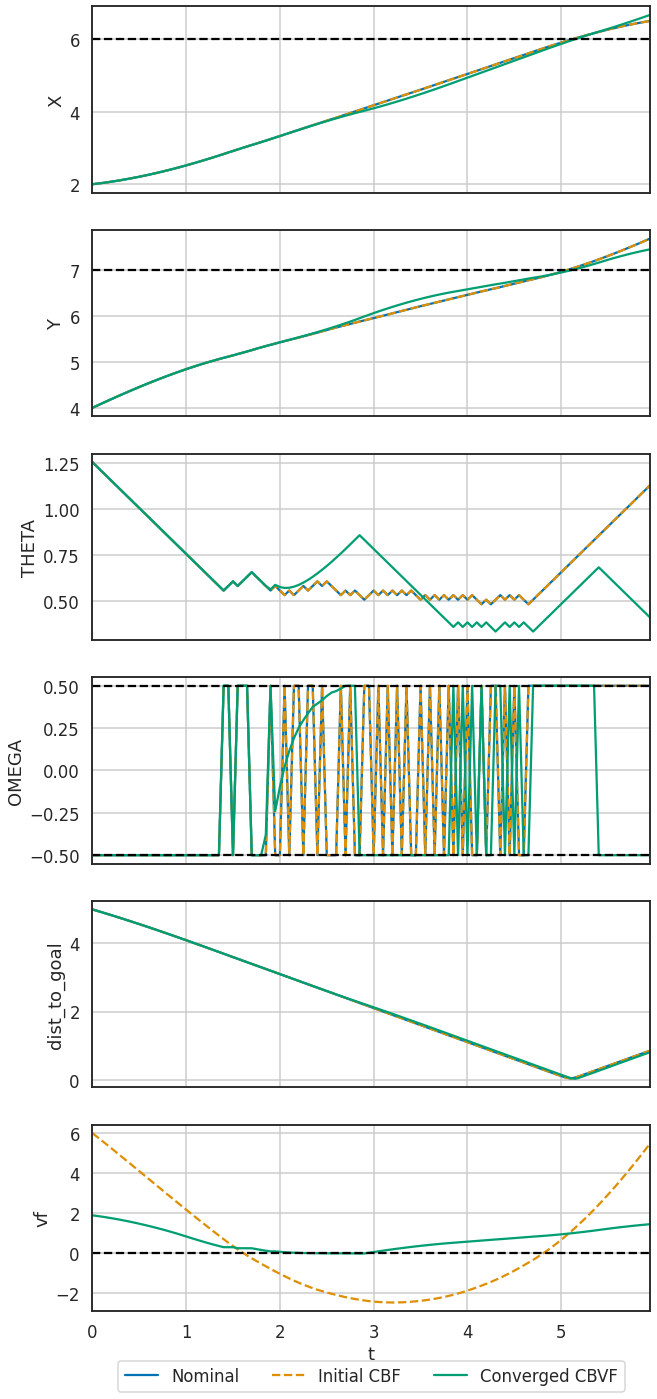

In [27]:
fig_handle = ts_experiment.plot(dyn, results_df, extra_measurements=['dist_to_goal', 'vf'])
fig_ts = fig_handle[0][1]
axs = fig_ts.axes
axs[0].plot(axs[0].lines[0]._x, 6 * np.ones_like(axs[0].lines[0]._x), '--', color='black')
axs[1].plot(axs[1].lines[0]._x, 7 * np.ones_like(axs[1].lines[0]._x), '--', color='black')
axs[3].plot(axs[3].lines[0]._x, .5 * np.ones_like(axs[3].lines[0]._x), '--', color='black')
axs[3].plot(axs[3].lines[0]._x, -.5 * np.ones_like(axs[3].lines[0]._x), '--', color='black')
axs[-1].plot(axs[-1].lines[-1]._x, 0 * np.ones_like(axs[-1].lines[-1]._x), '--', color='black')
for ax in axs:
    ax.lines[1].set_linestyle('--')
    ax.grid()

axs[-1].legend(["Nominal", "Initial CBF", "Converged CBVF"], ncol=3, loc='center', bbox_to_anchor=(0.5, -0.35));


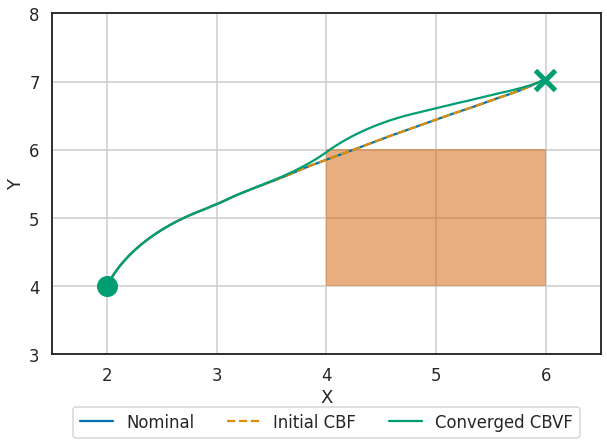

In [28]:
fig_handle = ss_experiment.plot(dyn, updated_df)
fig_ss = fig_handle[0][1]
fig_ss.tight_layout()
ax = fig_ss.axes[0]
ax.grid(True)
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.lines[3].set_linestyle('--')

ax.lines[-1].set_markersize(20)
ax.lines[-2].set_markersize(20)
ax.lines[-1].set_markeredgewidth(5)
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 0], levels=[-10, 0], colors='r', alpha=.5);
ax.legend(ax.lines[::3], ["Nominal", "Initial CBF", "Converged CBVF"], ncol=3, loc='center', bbox_to_anchor=(0.5, -0.2));

## Visualizations for paper + demo + videos

In [29]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.animation as anim

### Figure in paper

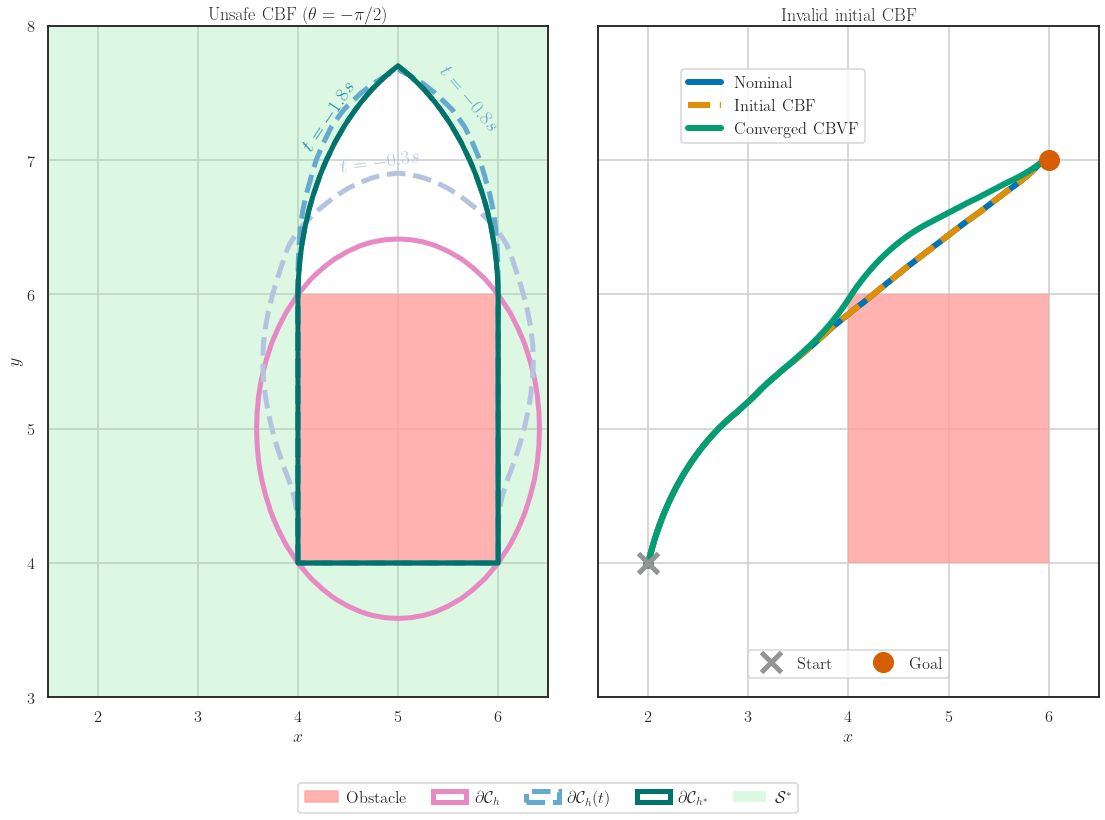

In [34]:
fig_comb, axs = plt.subplots(1, 2, figsize=(16, 12 ), sharey=True)
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("Set2", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()

proxy = [] 
ax=axs[0]
offset = 0
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], colors=gen_colors[3], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[3], fc='white', lw=5)
        for pc in cont.collections]

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[5][..., offset], levels=[0], colors=blue_colors[1], linestyles ='dashed', linewidths=5)
a = ax.clabel(cs, cs.levels, inline=False, fmt="$t=-0.3s$", fontsize=20, inline_spacing=-10, manual=[(5, 6.5)])
for l in a:
        l.set_va('bottom')
# ax.clabel(cs, inline=False, rightside_up=False, fontsize=20, fmt='$t=-0.3 s$', inline_spacing=3, colors = 'k')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[15][..., offset], levels=[0], colors=blue_colors[2], linestyles ='dashed', linewidths=5)
contourlabel0 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-0.8s$', inline_spacing=3, manual=[(5,7)])
for l in contourlabel0:
        l.set_va('bottom')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[35][..., offset], levels=[0], colors=blue_colors[3], linestyles ='dashed', linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[2], fc='white', linestyle='dashed', lw=5)
        for pc in cs.collections]
contourlabel1 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-1.8s$', inline_spacing=-30, manual=[(4.5, 7)])
for l in contourlabel1:
        l.set_va('bottom')

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[-1][..., offset], levels=[0], colors=blue_colors[-1], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[-1], fc='white', lw=5)
        for pc in cs.collections]


proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel('$y$')
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.set_title(r"Unsafe CBF ($\theta=-\pi / 2$)")
ax = axs[1]
ss_experiment.plot(dyn, updated_df, ax=ax)
ax.grid(True)
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.lines[3].set_linestyle('--')

pal = sns.color_palette("colorblind")
sns.set_palette("colorblind")

l1 = ax.plot(x0[0], x0[1], 'x', markersize=20, mew=5, color=pal[7])
l2 = ax.plot(opt_ctrl.target[0], opt_ctrl.target[1], 'o', markersize=20, color=pal[3])
miscs = [l1, l2]
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 0], levels=[-10, 0], colors=alt_colors[3], alpha=.8)
ax.set_ylabel(None)
ax.set_xlabel("$x$")
axs[1].set_title('Invalid initial CBF')

axs[0].legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\partial \mathcal{C}_{h^*}$", "$\mathcal{S}^*$"], ncol=5, loc='center', bbox_to_anchor=[1, -.15], columnspacing=1.6, handletextpad=0.5)
leg = axs[1].legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', frameon=True, handletextpad=0.6)
axs[1].legend([ax.lines[0], ax.lines[3], ax.lines[6]], ["Nominal", "Initial CBF", "Converged CBVF"], bbox_to_anchor=[.35, 0.88], ncol=1, columnspacing=1.5, handletextpad=0.8, loc='center', frameon=True)
axs[1].add_artist(leg)

fig_comb.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)


### Animation of 0-superlevel set

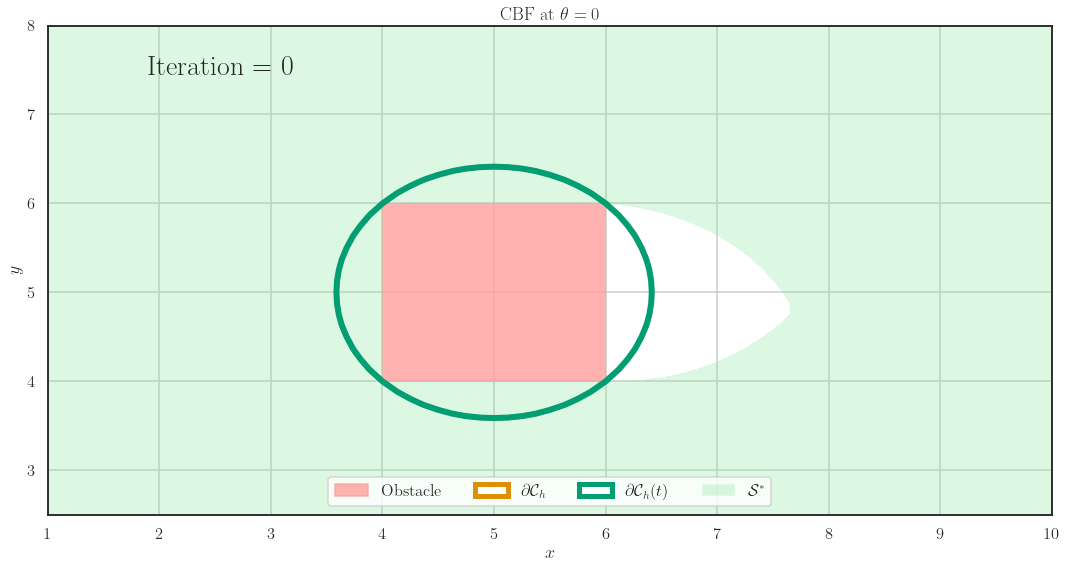

In [31]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[i][..., 21], levels=[0], colors=gen_colors[2])
# sns.set_theme()
# plt.style.use('classic')
filename = "dubins_wscbf_cbf_hjr_contour.mp4"
fig, ax = plt.subplots(1, 1, figsize=(18,9 ))
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("colorblind", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()
proxy = [] 
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 21], levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., 21], levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., 21], levels=[0], colors=gen_colors[1], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[1], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., 21], levels=[0], colors=gen_colors[2], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[2], fc='white', lw=5)
        for pc in cont.collections]


proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
# ax.text(contourlabel0)
# ax.text(contourlabel1)
ax.set_xlim([1, 10])
ax.set_ylim([2.5, 8])
ax.set_ylabel("$y$")
ax.set_title(r"CBF at $\theta=0$")
ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\mathcal{S}^*$"], ncol=4, loc='lower center')

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values.shape[0] * 5 // 16, interval=100)
# animation.save(filename, writer='ffmpeg')

### 3D Figure

In [32]:
# elem1=go.Isosurface(x=np.array(grid.states[..., 0][::4, ::4, ::4]).ravel(),
#                              y=np.array(grid.states[..., 1][::4, ::4, ::4]).ravel(),
#                              z=np.array(grid.states[..., 2][::4, ::4, ::4]).ravel(),
#                              value=np.array(target_values_hjr[-1][::4, ::4, ::4]).ravel(),
#                              colorscale="jet",
#                              isomin=0,
#                              surface_count=1,
#                              isomax=0)
# elem2 = go.Scatter3d(x=np.array(target[0]), y=np.array(target[1]), z=np.array(target[2]))
# elem3 = go.Scatter3d(x=np.array(states)[:, 0], y=np.array(states)[:, 1], z=np.array(states)[:, 2])
# elem4 = go.Scatter3d(x=np.array(states[0][0]), y=np.array(states[0][1]), z=np.array(states[0][2]))


# fig = go.Figure(data=[elem1, elem2, elem3, elem4])

In [33]:
# py.offline.iplot(fig, filename='3d-surface-mesh')